# Capstone Project 1 - In-Depth Analysis
## Name: Brock Nosbisch

# Summary:

### I ran the entire dataset using Logistic Regression, k-NN, Random Forest, and SVM and also ran each for 3 different buckets of Monthly Incomes.  The best overall results for Predicting Defaults is using the Logistic Regression using Balanced Weight.  65% of the Defaults were predicted but a large amount of non-defaults were mislabled as defaults (24%).  Similar results were returned when running the Monthly Income buckets using Logistic Regression.

### I also performed the same above tests but on a custom scorer that can be modified to show the profit / loss using different algorithms.  The custom scoring has 3 cost factors, Average Loan Amount, Average Interest Rate (revenue taken in), and Average Loan Length.  These factors have been set to $50,000, 4%, and 2 years respectively. 

### Using these factors, if the scorer correctly predicts a non-defaulter then the profit is 4,000 (loan amount x rate x length).  If the scorer incorrectly labels a defaulter as a non-defaulter then the loss is 50,000 (loan amount).  If the scorer incorrectly labels a non-defaulter as a defaulter then the loss is 4,000 (profit we would have taken in).
### The below results show the Profits taken in for each algorithm.  The Logistic Regression (3 Monthly Income Buckets), Logistic Regression (Balanced Class Weight), and Random Forest Resampling (Default Counts = Non-Default Counts) all had Profits of over 85+ million dollars.  All others resulted in 65 million dollars or less.
### Results for each model tested:
| Algorithm                                                        | Profit         |
|------------------------------------------------------------------|----------------|
| Logistic Regression                                              | 54,246,000.00  |
| Logistic Regression (tuned parameters)                           | 56,654,000.00  |
| Logistic Regression (Balanced Class   Weight)                    | 89,022,000.00  |
| k-NN (Best Neighbors, Uniform Weight)                            | 26,746,000.00  |
| k-NN Resampling (Default Counts =   Non-Default Counts)          | 11,202,000.00  |
| Random Forest (Max Features = 10)                                | 59,054,000.00  |
| Random Forest (Balanced Weight Class)                            | 52,778,000.00  |
| Random Forest Resampling (Default Counts   = Non-Default Counts) | 86,850,000.00  |
| Logistic Regression (3 Monthly Income   Buckets)                 | 89,310,000.00  |
| k-NN (3 Monthly Income Buckets)                                  | 32,474,000.00  |
| Random Forest (3 Monthly Income Buckets)                         | 64,592,000.00  |


# Load Packages / Data / Notebooks

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from scipy import stats
# from statsmodels.nonparametric.kernel_regression import KernelReg

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report, accuracy_score, SCORERS
from sklearn.metrics.scorer import make_scorer
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier

file_name = 'eda_out.csv'
df = pd.read_csv(file_name, header=0, na_values ='-1')
df.set_index('id', inplace=True)
# df.info()


In [77]:
def pearsonr_ci(x,y,alpha=0.05):

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    low_z, high_z = r_z-z*se, r_z+z*se
    low, high = np.tanh((low_z, high_z))
    return r, p, low, high

# Bootstrap Replicates
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

# Test SVM
# Pass X_train, y_train, X_test, y_test, Maximum Iterations you want, C values in a list 
def svm_test(X_train, y_train, X_test, y_test, maxiter=1000, crange=[0.01,0.1,1,10,100]):
    # X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=10)
    model = svm.LinearSVC(C=1, random_state=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #tune parameter C
    # crange = [0.01,0.1,1,10,100,1000]
    for num in crange:
        model = svm.LinearSVC(C=num, max_iter = maxiter)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print ('C=' + str(num) + ',score={}'.format(accuracy_score(y_test,y_pred)))
        print(confusion_matrix(y_test, y_pred))
        
def print_stats(y_test, y_pred):
    
    profit = 0
    
    avg_loan_amount = 50000 # Average Loan Amount
    avg_interest_rate = .04 # Average interest rate we take in for paid loans
    avg_loan_years = 2      # Average number of years it takes to payoff a loan
    
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print()
    print()
    tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()
    total_profit = (tp * avg_loan_amount * avg_interest_rate * avg_loan_years) + (fp * avg_loan_amount * avg_interest_rate * avg_loan_years * -1) + (fn * avg_loan_amount * -1)
    print('Total Profit {}'.format(total_profit))
    print()
    print()
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    print()
    print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))
    

def print_cv_scores(clf, X_test, y_test, scoring_type, n_CV=5, jobs=-1):
    cv_scores = cross_val_score(clf, X_test, y_test, cv=n_CV, scoring=scoring_type, n_jobs=jobs)
    print('CV Scores:')
    print(cv_scores)
    print()
    cv_score_avg = np.mean(cv_scores)
    print('Total Profit: ' + str(cv_score_avg*n_CV))
    print()



## Custom Scoring Function

In [78]:
  
# 20190625 - New Function to be used as Custom Scorer
def prof_scorer(y_test, y_pred):
    
    cnt00 = 0
    cnt01 = 0
    cnt10 = 0
    cnt11 = 0
    
    profit = 0
    
    avg_loan_amount = 50000 # Average Loan Amount
    avg_interest_rate = .04 # Average interest rate we take in for paid loans
    avg_loan_years = 2      # Average number of years it takes to payoff a loan

    for index in range(len(y_test)):
        y = y_test.iloc[index]
        y_p = y_pred[index]

        if y == 0 and y_p == 0: # TP
            profit += avg_loan_amount * avg_interest_rate * avg_loan_years # amt * rate * years = profit
            cnt00 += 1
        elif y == 0 and y_p == 1: # FP
            profit -= avg_loan_amount * avg_interest_rate * avg_loan_years # amt * rate * years = profit
            cnt01 += 1
        elif y == 1 and y_p == 0: # FN
            profit -= avg_loan_amount # We are assuming that a False Positive will result in losing the entire loan amount.
            cnt10 += 1
        elif y == 1 and y_p == 1: # TN
            profit += 0  # No cost since we identified the Defaulters
            cnt11 += 1
        else:
            raise ValueError("Something went wrong " + str(index))

    return profit

# This is our customer Scorer to use.
profit_scorer = make_scorer(prof_scorer, greater_is_better=True)  # The higher the revenue the better.


In [79]:

# Find monthly income median
df['monthly_income'][df['monthly_income'].isnull()] = 0
df.astype({'monthly_income':'int64'})
monthly_median = np.median(df['monthly_income'])
df.loc[df.monthly_income == 0, 'monthly_income'] = monthly_median # Set the 0's to median value.

# Need to do a little clean up on number_of_dependents
df['number_of_dependents'] = df['number_of_dependents'].fillna(0)



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Train / Test / Split

In [80]:

X = df.drop(columns = ['serious_delinquent','age_bucket_name','monthly_income_name']) # ,'monthly_income']) # Drop columns not needed.
y = df['serious_delinquent']

# Split the Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50) 


# Split the Training and Test Sets for upsampling.
# I am using the same Random Stage so the data will be the same as above BUT to resample, we need X_train_2 to have the 'serious_delinquent' value so that we can balance the data.
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=.4, random_state=50) 

X_train_2['serious_delinquent'] = y_train_2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


### Resampling to Upsample

In [81]:
# Resampling to Upsample our Defaults.

from sklearn.utils import resample

# Separating default and non-defaults
df_default = X_train_2[X_train_2['serious_delinquent'] == 1] 
df_no_default = X_train_2[X_train_2['serious_delinquent'] == 0]

print('Number of Defaults: {}'.format(np.ma.count(df_default['serious_delinquent'])))
print('Number of Non-Defaults: {}'.format(np.ma.count(df_no_default['serious_delinquent'])))

resample_count = np.ma.count(df_no_default['serious_delinquent']) - np.ma.count(df_default['serious_delinquent'])
print('Difference: {}'.format(resample_count)) # This is the amount of resamples I need to make
print()

df_default_samples = resample(df_default, replace=True, n_samples=resample_count, random_state=50) # Resampling
print('Number of New Defaults (resampled): {}'.format(np.ma.count(df_default_samples['serious_delinquent'])))
print()

df_resampled = pd.concat([df_default, df_default_samples, df_no_default]) # combine all data
print('Count of Records after Resampling: {}'.format(np.ma.count(df_resampled['serious_delinquent'])))



# Resampled dependent/independent.
X_r = df_resampled.drop(columns = ['serious_delinquent']) # ,'age_bucket_name','monthly_income_name']) # Drop columns not needed.
y_r = df_resampled['serious_delinquent']

X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(X_r, y_r, test_size=.4, random_state=50)


Number of Defaults: 5933
Number of Non-Defaults: 83905
Difference: 77972

Number of New Defaults (resampled): 77972

Count of Records after Resampling: 167810


# Logistic Regression

### The Confusion Matrix is showing the below which looks good:
* Accuracy was 94% (56,177 out of 59,892)
* Precision was 94% (tp / (tp + fp))
* Recall was 99% (tp / (tp + fn))
* F1 Score is 96% (2 * ((p * r) / (p + r)))

### But if I look at how well I did predicting the Defaults, the model predicted a total of 1,003 Defaults and 617 of those were actual Defaults.  The total actual count of Defaults was 3,946.  These results are not satisfactory.
* Predicted 617 defaults out of 3,946 total defaults (16%)
* Out of 1,003 predicted defaults, 617 were actual defaults (62%)
* F1 Score is 25%
### The Average 10-fold Cross Validation score is 93.8%.


In [82]:
n_CV = 10

logreg = LogisticRegression(solver='liblinear') # Create the classifier

print_cv_scores(logreg, X_test, y_test, profit_scorer, n_CV, -1) # Print cross_val_score using custom scoring 

logreg.fit(X_train, y_train) # Fit the classifier to the training data

y_pred = logreg.predict(X_test) # Predict the labels of the test set

print_stats(y_test, y_pred)


CV Scores:
[5204000. 5856000. 5244000. 5628000. 6056000. 5906000. 6074000. 6100000.
 6516000. 5092000.]

Total Profit: 57676000.0



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Confusion Matrix:
[[55560   386]
 [ 3329   617]]


Total Profit 54246000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     55946
           1       0.62      0.16      0.25      3946

   micro avg       0.94      0.94      0.94     59892
   macro avg       0.78      0.57      0.61     59892
weighted avg       0.92      0.94      0.92     59892


Accuracy Score: 0.9379716823615842


### It seems that using optimizing the parameters did not help much since the matrix is about the same as above but the total profit is a little higher.

In [84]:
# GridSearchCV with LogReg
n_CV = 5

logreg = LogisticRegression(solver='liblinear') # Create the classifier

print_cv_scores(logreg, X_test, y_test, profit_scorer, n_CV, -1) # Print cross_val_score using custom scoring 

penalty = ['l1', 'l2'] # regularization penablty space
C = np.logspace(0, 4, 10) # regularization hyperparameter space

param_grid = dict(C=C, penalty=penalty)
# scoring = {'AUC': 'roc_auc', 'ROC AUC SCORE': 'roc_auc_score', 'Balanced Accuracy': 'balanced_accuracy_score'}

logreg_cv = GridSearchCV(logreg, param_grid, cv=n_CV, scoring=profit_scorer, n_jobs=-1) # 5 fold

logreg_cv.fit(X_train, y_train) # Fit the classifier to the training data

y_pred = logreg_cv.predict(X_test) # Predict the labels of the test set

print_stats(y_test, y_pred)


CV Scores:
[11444000. 10674000. 12140000. 12172000. 11306000.]

Total Profit: 57736000.0

Confusion Matrix:
[[55511   435]
 [ 3273   673]]


Total Profit 56654000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     55946
           1       0.61      0.17      0.27      3946

   micro avg       0.94      0.94      0.94     59892
   macro avg       0.78      0.58      0.62     59892
weighted avg       0.92      0.94      0.92     59892


Accuracy Score: 0.9380885594069325


## Logistic Regression (Balanced)
### After passing the class_weight='balanced' parameter, the Confusion Matrix is showing the below which appears to be worse than above.
* Accuracy was 83.8% (50,234 / 59,892)
* Precision was 97%
* Recall was 85%
* F1 Score is 91%

### But since the weighting was balanced (n_samples / (n_classes * np.bincount(y))), the model predicted a total of 10,866 Defaults and 2,577 of those were actual Defaults.  The total actual count of Defaults was 3,946.
* Predicted 2,577 defaults out of 3,946 total defaults (65%)
* Out of 10,866 predicted defaults, 2,577 were actual defaults (24%)
* F1 Score is 35%

### So using the Balanced method gave us a much higher percentage (65%) of finding all the Defaults but 8,284 predicted defaults did not actually default (15% of all non-defaulters).  This may seem like the balanced model was worse but the model is being used to find the people who will default.  Since defaulters cost the company a lot more than the non-defaulters make in revenue then wrongly classifying a non-defaulter as a defaulter is an okay trade-off.


In [85]:
# Logistic Regression (balanced)

logreg_bal = LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced', C=1) # Create the classifier

print_cv_scores(logreg_bal, X_test, y_test, profit_scorer, n_CV, -1) # Print cross_val_score using custom scoring 

logreg_bal.fit(X_train, y_train) # Fit the classifier to the training data

y_pred = logreg_bal.predict(X_test) # Predict the labels of the test set

print_stats(y_test, y_pred)


CV Scores:
[17712000. 17496000. 10160000. 17192000.  7460000.]

Total Profit: 70020000.0

Confusion Matrix:
[[47657  8289]
 [ 1369  2577]]


Total Profit 89022000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     55946
           1       0.24      0.65      0.35      3946

   micro avg       0.84      0.84      0.84     59892
   macro avg       0.60      0.75      0.63     59892
weighted avg       0.92      0.84      0.87     59892


Accuracy Score: 0.838743070860883


### The Average 10-fold Cross Validation score is 84%.

In [86]:
# Cross Validation w/ Balance
n_CV = 10

logreg3 = LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced', C=1) # Create the classifier

print_cv_scores(logreg3, X_test, y_test, profit_scorer, n_CV, -1) # Print cross_val_score using custom scoring 


CV Scores:
[8304000. 9756000. 8222000. 9230000. 9746000. 9078000. 8992000. 8250000.
 9066000. 8720000.]

Total Profit: 89364000.0



## ROC Curve of Balanced Logistic Regression

ROC AUC Score: 0.8254011602202247



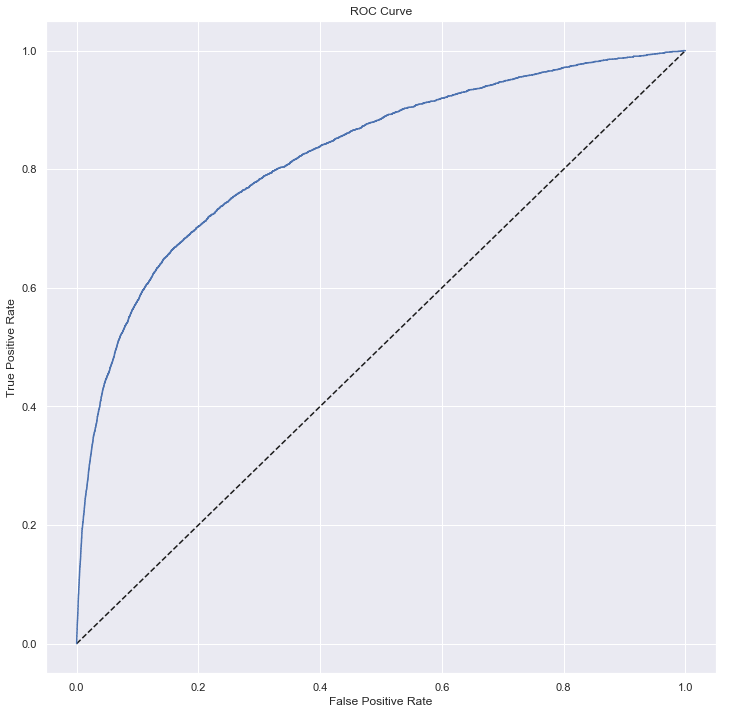

In [87]:
# ROC Curve
y_pred_prob = logreg_bal.predict_proba(X_test)[:,1]

auc_score = roc_auc_score(y_test, y_pred_prob)
print('ROC AUC Score: ' + str(auc_score))
print()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) # False Positive, True Positive, Threshold

plt.figure(figsize=(12,12))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


# k-NN

### Finding the Best Params / Score to use results in using 5 k-fold and results in a k-NN Score of 93.4%

In [88]:
n_CV = 5

param_grid = {'n_neighbors': np.arange(1,12)}

knn = KNeighborsClassifier()

print_cv_scores(knn, X_test, y_test, profit_scorer, n_CV, -1) # Print cross_val_score using custom scoring 

knn_cv = GridSearchCV(knn, param_grid, cv=n_CV, scoring=profit_scorer, n_jobs=-1) # 5 fold

knn_cv.fit(X_train, y_train)

print('k-NN Best Params: {}'.format(knn_cv.best_params_))
print('k-NN Best Score: {}'.format(knn_cv.best_score_))

knn_neighbors = knn_cv.best_params_


CV Scores:
[5388000. 5186000. 5456000. 5466000. 5342000.]

Total Profit: 26838000.0

k-NN Best Params: {'n_neighbors': 4}
k-NN Best Score: 7917998.352590218


### Use the k-NN Best n-neighbors.

In [141]:
knn = KNeighborsClassifier(n_neighbors=knn_neighbors['n_neighbors'], weights='uniform')

print_cv_scores(knn, X_test, y_test, profit_scorer, n_CV, -1) # Print cross_val_score using custom scoring 

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('Prediction: {}'.format(y_pred))
print('k-NN Score: {}'.format(knn.score(X_test, y_test)))

print_stats(y_test, y_pred)

CV Scores:
[5448000. 5278000. 5434000. 5286000. 5196000.]

Total Profit: 26642000.0

Prediction: [0 0 0 ... 0 0 0]
k-NN Score: 0.9333466907099446
Confusion Matrix:
[[55885    61]
 [ 3931    15]]


Total Profit 26746000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     55946
           1       0.20      0.00      0.01      3946

   micro avg       0.93      0.93      0.93     59892
   macro avg       0.57      0.50      0.49     59892
weighted avg       0.89      0.93      0.90     59892


Accuracy Score: 0.9333466907099446


### The Confusion Matrix for k-NN with k=10 has the below results which look really good!
* Accuracy was 93% (55,944 / 59,892)
* Precision was 93%
* Recall was 100%
* F1 Score is 97%

### But the model basically just said that all but 3 people would not default.  This does not help us since we want to identify those defaulters.  Next I will upsample the defaults.


In [142]:
#print_stats(y_test, y_pred)

### Upsampling the Defaults so that the occurence of Defaults vs. non-Defaults is 50/50.

### Resampling with k=10 (best param / score).  With this method we were able to predict 1,649 out of 3,986 defaults but mislabeled 16,004 non-defaults as defaults.

In [143]:

knn = KNeighborsClassifier(n_neighbors=knn_neighbors['n_neighbors'])

knn.fit(X_r_train, y_r_train)

##################################################

# Now running on the original dataset to see what our output is.
y_r_pred = knn.predict(X_test)  # Use the actual dataset to test

print('Prediction: {}'.format(y_r_pred))
print('k-NN Score: {}'.format(knn.score(X_test, y_test)))
print()

# Running the below doesn't really tell us much because the prediction was run on the balanced dataset.

print_stats(y_test, y_r_pred)


Prediction: [0 0 0 ... 0 0 0]
k-NN Score: 0.8199091698390436

Confusion Matrix:
[[48167  7779]
 [ 3007   939]]


Total Profit 11202000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     55946
           1       0.11      0.24      0.15      3946

   micro avg       0.82      0.82      0.82     59892
   macro avg       0.52      0.55      0.52     59892
weighted avg       0.89      0.82      0.85     59892


Accuracy Score: 0.8199091698390436


### ROC Curve results in an AUC Score of 59.7%

ROC AUC Score: 0.5720571837346088



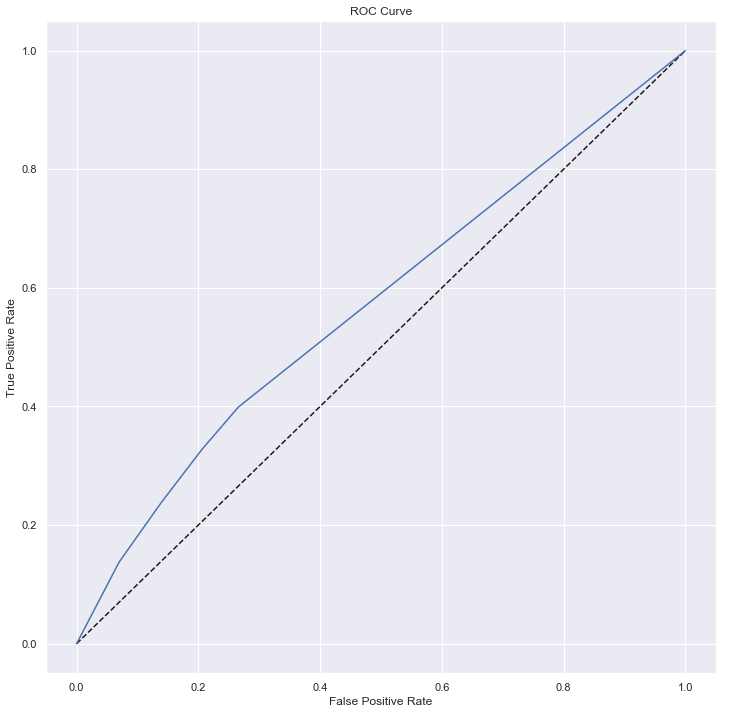

In [144]:
# ROC Curve
y_r_pred_prob = knn.predict_proba(X_test)[:,1]

auc_score = roc_auc_score(y_test, y_r_pred_prob)
print('ROC AUC Score: ' + str(auc_score))
print()

fpr, tpr, thresholds = roc_curve(y_test, y_r_pred_prob) # False Positive, True Positive, Threshold

plt.figure(figsize=(12,12))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


# Random Forests

### Finding the Best Features to Use results in Age (10.4%), Debt Ratio (14.7%), Monthly Income (11.6%), and Unsecured Lines (17%) being the best features.

In [94]:
# Feature Importance

features = X_train.keys() # Store Feature Names

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, n_jobs=-1) # 1000 Trees
clf.fit(X_train, y_train)

for feature in zip(features, clf.feature_importances_): # Print each feature with gini score.
    print(feature)

('age', 0.10415494783280503)
('age_bucket', 0.031253023646079854)
('debt_ratio', 0.14709674909171985)
('debt_ratio_bucket', 0.027006214800039098)
('debt_ratio_name', 0.026826965061575777)
('monthly_income', 0.11637439653958102)
('monthly_income_bucket', 0.031472455842119884)
('past_due_30_59', 0.03543735229983863)
('past_due_30_59_flag', 0.014810692978250412)
('past_due_60_89', 0.023327999714990246)
('past_due_60_89_flag', 0.017014642318784353)
('past_due_90_plus', 0.052225674522146284)
('past_due_90_plus_flag', 0.041534394540609774)
('open_credit_lines', 0.0869968850499308)
('unsecured_lines', 0.1705596201949941)
('real_estate_loans', 0.032959304331599125)
('number_of_dependents', 0.0409486812349354)


### Using all Features in the actual data set gives not so good results.  Only 733 of the 3,946 defaults were predicted.

In [140]:
# Using the actual data

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, n_jobs=-1) # max_depth=100,
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print_stats(y_test, y_pred)
# print(clf.get_params())



clf = RandomForestClassifier(n_estimators=1000,  random_state=50, max_depth=100, n_jobs=-1) # 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print_stats(y_test, y_pred)
# print(clf.get_params())



clf = RandomForestClassifier(n_estimators=1000,  random_state=50, max_features=10, n_jobs=-1) # max_depth=100,
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print_stats(y_test, y_pred)
# print(clf.get_params())


Confusion Matrix:
[[55344   602]
 [ 3213   733]]


Total Profit 58318000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     55946
           1       0.55      0.19      0.28      3946

   micro avg       0.94      0.94      0.94     59892
   macro avg       0.75      0.59      0.62     59892
weighted avg       0.92      0.94      0.92     59892


Accuracy Score: 0.93630201028518
Confusion Matrix:
[[55344   602]
 [ 3213   733]]


Total Profit 58318000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     55946
           1       0.55      0.19      0.28      3946

   micro avg       0.94      0.94      0.94     59892
   macro avg       0.75      0.59      0.62     59892
weighted avg       0.92      0.94      0.92     59892


Accuracy Score: 0.93630201028518
Confusion Matrix:
[[55286   660]
 [ 3189   757]]


Total Profit 59054000.0


C

In [96]:
n_CV = 5

param_grid = {'n_estimators': [1000], 'max_depth': [5, 10, 15, 20, 25, 30, 50]}

clf_cv = GridSearchCV(clf, param_grid, cv=n_CV, scoring=profit_scorer, n_jobs=-1) # 5 fold

clf_cv.fit(X_train, y_train)

print('Random Forest Best Params: {}'.format(clf_cv.best_params_))
print('Random Forest Best Score: {}'.format(clf_cv.best_score_))


Random Forest Best Params: {'max_depth': 25, 'n_estimators': 1000}
Random Forest Best Score: 16676395.600970635


### Using the Balanced class weight did a little worse in that it only predicted 603 out of the 3,946 defaults.

In [146]:
# Using the Actual Dataset with Class_Weight = 'balanced'

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, class_weight = 'balanced', n_jobs=-1) # max_depth=100,
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print_stats(y_test, y_pred)


Confusion Matrix:
[[55464   482]
 [ 3343   603]]


Total Profit 52778000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     55946
           1       0.56      0.15      0.24      3946

   micro avg       0.94      0.94      0.94     59892
   macro avg       0.75      0.57      0.60     59892
weighted avg       0.92      0.94      0.92     59892


Accuracy Score: 0.9361350430775396


### Instead of using the Balanced class weight parameter, I am going to use my balanced dataset where the number of default records is the same as the number of non-default records.
### This results in what looks to be pretty decent results.  1,567 out of the 3,946 defaults were predicted and 2,248 non-defaulters were predicted to default.

In [98]:
# Using the Balanced Dataset

clf = RandomForestClassifier(n_estimators=1000, random_state=50, n_jobs=-1) # max_depth=100,
clf.fit(X_r_train, y_r_train)

y_r_pred = clf.predict(X_test) # Use the actual dataset to test

print_stats(y_test, y_r_pred)


Confusion Matrix:
[[53698  2248]
 [ 2379  1567]]


Total Profit 86850000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     55946
           1       0.41      0.40      0.40      3946

   micro avg       0.92      0.92      0.92     59892
   macro avg       0.68      0.68      0.68     59892
weighted avg       0.92      0.92      0.92     59892


Accuracy Score: 0.9227442730247779


### The ROC AUC Score is 84.4.

ROC AUC Score: 0.8437428141237272



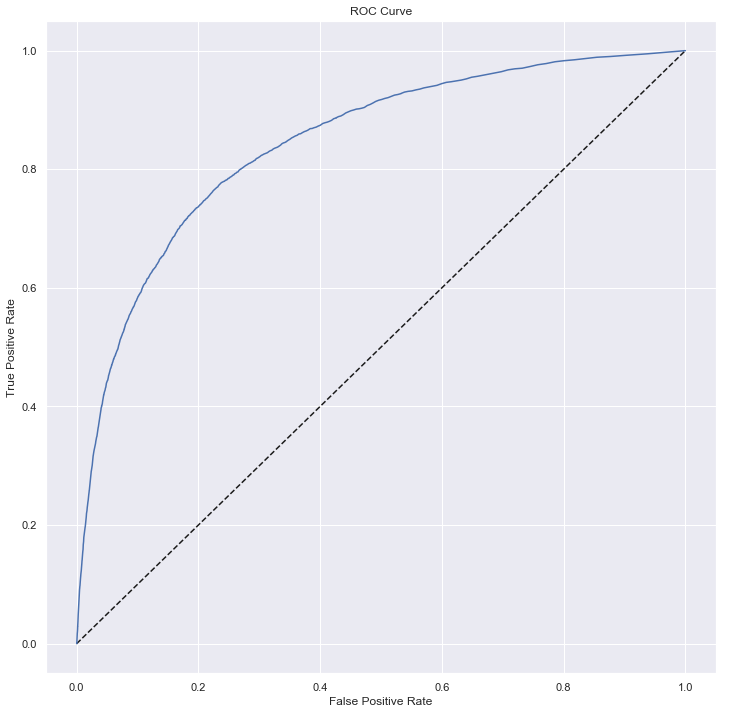

In [99]:
# ROC Curve
y_r_pred_prob = clf.predict_proba(X_test)[:,1]

auc_score = roc_auc_score(y_test, y_r_pred_prob)
print('ROC AUC Score: ' + str(auc_score))
print()

fpr, tpr, thresholds = roc_curve(y_test, y_r_pred_prob) # False Positive, True Positive, Threshold

plt.figure(figsize=(12,12))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


# SVM

## The SVM results were all sub-par since not many of the defaults were predicted.

In [100]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler


In [ ]:

# svm_test(X_train, y_train, X_test, y_test, 5000, [.5, 1.0, 1.5, 2.0, 4.0, 8.0, 10.0])

In [101]:
linSVC = svm.LinearSVC(random_state=50,  max_iter = 1000, C=4.0) # tol=1e-5,
linSVC.fit(X_train, y_train)

y_r_pred = linSVC.predict(X_test)

print_stats(y_test, y_r_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Confusion Matrix:
[[53181  2765]
 [ 3518   428]]


Total Profit 25764000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     55946
           1       0.13      0.11      0.12      3946

   micro avg       0.90      0.90      0.90     59892
   macro avg       0.54      0.53      0.53     59892
weighted avg       0.88      0.90      0.89     59892


Accuracy Score: 0.8950945034395245


# Splitting Up Data Based on Monthly Income

### Splitting up the dataset by Monthly Income into 3 buckets.  
* < median monthly income
* = median monthly income (I set all NULL and 0 monthly incomes to the median value)
* \> median monthly income

### Train / Test / Split
### There will now be 3 DataFrames, Low Income, Median Income, High Income

In [103]:

# Lower than Monthly Income median
df_low = df[df['monthly_income'] < df['monthly_income'].median()].copy()

X_low = df_low.drop(columns = ['serious_delinquent','age_bucket_name','monthly_income_name']) # ,'monthly_income']) # Drop columns not needed.
y_low = df_low['serious_delinquent']

# Split the Training and Test Sets
X_low_train, X_low_test, y_low_train, y_low_test = train_test_split(X_low, y_low, test_size=.4, random_state=50) 


# Median Monthly Income median (I set all 0s to median value)
df_med = df[df['monthly_income'] == df['monthly_income'].median()].copy()

X_med = df_med.drop(columns = ['serious_delinquent','age_bucket_name','monthly_income_name']) # ,'monthly_income']) # Drop columns not needed.
y_med = df_med['serious_delinquent']

# Split the Training and Test Sets
X_med_train, X_med_test, y_med_train, y_med_test = train_test_split(X_med, y_med, test_size=.4, random_state=50) 


# Higher (or equal to) than Monthly Income median
df_high = df[df['monthly_income'] > df['monthly_income'].median()].copy()

X_high = df_high.drop(columns = ['serious_delinquent','age_bucket_name','monthly_income_name']) # ,'monthly_income']) # Drop columns not needed.
y_high = df_high['serious_delinquent']

# Split the Training and Test Sets
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high, y_high, test_size=.4, random_state=50) 


## Logistic Regression

### Splitting up the Monthly Income into the 3 buckets produced okay results for each bucket.  The predictions were about the same as using balanced Logistic Regression with the entire training dataset.
#### Monthly Income < median
    * Predicted 1,018 out of 1,533 defaults. (66%)
    * Mislabeled 2,577 non-defaults as defaults. (16%)
#### Monthly Income = median
    * Predicted 454 out of 634 defaults. (72%)
    * Mislabeled 1,738 non-defaults as defaults. (15%)
#### Monthly Income > median
    * Predicted 1,098 out of 1,680 defaults. (65%)
    * Mislabeled 4,563 non-defaults as defaults. (16%)
        

In [104]:

logreg_low = LogisticRegression(solver='liblinear', class_weight='balanced', C=2.0, n_jobs=-1) # Create the classifier
logreg_low.fit(X_low_train, y_low_train) # Fit the classifier to the training data

y_pred_low = logreg_low.predict(X_low_test) # Predict the labels of the test set

print_stats(y_low_test, y_pred_low)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Confusion Matrix:
[[13334  2577]
 [  515  1018]]


Total Profit 17278000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90     15911
           1       0.28      0.66      0.40      1533

   micro avg       0.82      0.82      0.82     17444
   macro avg       0.62      0.75      0.65     17444
weighted avg       0.90      0.82      0.85     17444


Accuracy Score: 0.8227470763586333


In [105]:

logreg_med = LogisticRegression(solver='liblinear', class_weight='balanced', C=2.0, n_jobs=-1) # Create the classifier
logreg_med.fit(X_med_train, y_med_train) # Fit the classifier to the training data

y_pred_med = logreg_med.predict(X_med_test) # Predict the labels of the test set

print_stats(y_med_test, y_pred_med)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Confusion Matrix:
[[10138  1738]
 [  180   454]]


Total Profit 24600000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91     11876
           1       0.21      0.72      0.32       634

   micro avg       0.85      0.85      0.85     12510
   macro avg       0.59      0.78      0.62     12510
weighted avg       0.94      0.85      0.88     12510


Accuracy Score: 0.8466826538768985


In [106]:

logreg_high = LogisticRegression(solver='liblinear', class_weight='balanced', C=2.0, n_jobs=-1) # Create the classifier
logreg_high.fit(X_high_train, y_high_train) # Fit the classifier to the training data

y_pred_high = logreg_high.predict(X_high_test) # Predict the labels of the test set

print_stats(y_high_test, y_pred_high)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Confusion Matrix:
[[23696  4563]
 [  582  1098]]


Total Profit 47432000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.90     28259
           1       0.19      0.65      0.30      1680

   micro avg       0.83      0.83      0.83     29939
   macro avg       0.58      0.75      0.60     29939
weighted avg       0.93      0.83      0.87     29939


Accuracy Score: 0.8281505728314239


## k-NN

### Splitting up the Monthly Income into the 3 buckets produced high accuracy but this is because there were very little defaults predicted.
        

In [113]:
n_CV = 5

param_grid = {'n_neighbors': np.arange(1,12)}

knn_low = KNeighborsClassifier()

knn_low_cv = GridSearchCV(knn_low, param_grid, cv=n_CV, scoring=profit_scorer, n_jobs=-1) # 5 fold

knn_low_cv.fit(X_low_train, y_low_train)

y_pred_low = knn_low_cv.predict(X_low_test)

print('k-NN Best Params: {}'.format(knn_low_cv.best_params_))
print('k-NN Best Score: {}'.format(knn_low_cv.best_score_))

print_stats(y_low_test, y_pred_low)

knn_neighbors_low = knn_low_cv.best_params_


k-NN Best Params: {'n_neighbors': 1}
k-NN Best Score: -3932415.7303370787
Confusion Matrix:
[[14894  1017]
 [ 1361   172]]


Total Profit -12542000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     15911
           1       0.14      0.11      0.13      1533

   micro avg       0.86      0.86      0.86     17444
   macro avg       0.53      0.52      0.53     17444
weighted avg       0.85      0.86      0.86     17444


Accuracy Score: 0.8636780554918597


In [131]:
knn_low = KNeighborsClassifier(n_neighbors=knn_neighbors_low['n_neighbors'], weights='distance', n_jobs=-1) #

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50)

knn_low.fit(X_low_train, y_low_train)

y_pred_low = knn_low.predict(X_low_test)

print('Prediction: {}'.format(y_pred_low))
print('k-NN Score: {}'.format(knn_low.score(X_low_test, y_low_test)))

Prediction: [0 0 0 ... 0 0 0]
k-NN Score: 0.8636780554918597


In [132]:
print_stats(y_low_test, y_pred_low)

Confusion Matrix:
[[14894  1017]
 [ 1361   172]]


Total Profit -12542000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     15911
           1       0.14      0.11      0.13      1533

   micro avg       0.86      0.86      0.86     17444
   macro avg       0.53      0.52      0.53     17444
weighted avg       0.85      0.86      0.86     17444


Accuracy Score: 0.8636780554918597


In [134]:

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50)
n_CV = 5

param_grid = {'n_neighbors': np.arange(1,12)}

knn_med = KNeighborsClassifier()

knn_med_cv = GridSearchCV(knn_med, param_grid, cv=n_CV, scoring=profit_scorer, n_jobs=-1) # 5 fold

knn_med_cv.fit(X_med_train, y_med_train)

y_pred_med = knn_med_cv.predict(X_med_test)

print_stats(y_med_test, y_pred_med)

print('k-NN Best Params: {}'.format(knn_med_cv.best_params_))
print('k-NN Best Score: {}'.format(knn_med_cv.best_score_))
print()

knn_neighbors_med = knn_med_cv.best_params_


knn_med = KNeighborsClassifier(n_neighbors=knn_neighbors_med['n_neighbors'], weights='uniform')

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50)

knn_med.fit(X_med_train, y_med_train)

y_pred_med = knn_med.predict(X_med_test)

print('Prediction: {}'.format(y_pred_med))
print('k-NN Score: {}'.format(knn_med.score(X_med_test, y_med_test)))
print()

print_stats(y_med_test, y_pred_med)

Confusion Matrix:
[[11857    19]
 [  631     3]]


Total Profit 15802000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     11876
           1       0.14      0.00      0.01       634

   micro avg       0.95      0.95      0.95     12510
   macro avg       0.54      0.50      0.49     12510
weighted avg       0.91      0.95      0.92     12510


Accuracy Score: 0.9480415667466027
k-NN Best Params: {'n_neighbors': 7}
k-NN Best Score: 3852387.444041782

Prediction: [0 0 0 ... 0 0 0]
k-NN Score: 0.9480415667466027

Confusion Matrix:
[[11857    19]
 [  631     3]]


Total Profit 15802000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     11876
           1       0.14      0.00      0.01       634

   micro avg       0.95      0.95      0.95     12510
   macro avg       0.54      0.50      0.49     12510
weighted avg       0.91      0

In [135]:


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50)
n_CV = 5

param_grid = {'n_neighbors': np.arange(1,12)}

knn_high = KNeighborsClassifier()

knn_high_cv = GridSearchCV(knn_high, param_grid, cv=n_CV, scoring=profit_scorer, n_jobs=-1) # 5 fold

knn_high_cv.fit(X_high_train, y_high_train)

y_pred_high = knn_high_cv.predict(X_high_test)

print_stats(y_high_test, y_pred_high)

print('k-NN Best Params: {}'.format(knn_high_cv.best_params_))
print('k-NN Best Score: {}'.format(knn_high_cv.best_score_))
print()

knn_neighbors_high = knn_high_cv.best_params_


knn_high = KNeighborsClassifier(n_neighbors=knn_neighbors_high['n_neighbors'], weights='uniform')

knn_high.fit(X_high_train, y_high_train)

y_pred_high = knn_high.predict(X_high_test)

print('Prediction: {}'.format(y_pred_high))
print('k-NN Score: {}'.format(knn_high.score(X_high_test, y_high_test)))
print()

print_stats(y_high_test, y_pred_high)

Confusion Matrix:
[[28250     9]
 [ 1675     5]]


Total Profit 29214000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     28259
           1       0.36      0.00      0.01      1680

   micro avg       0.94      0.94      0.94     29939
   macro avg       0.65      0.50      0.49     29939
weighted avg       0.91      0.94      0.92     29939


Accuracy Score: 0.943752296335883
k-NN Best Params: {'n_neighbors': 4}
k-NN Best Score: 7534000.668047298

Prediction: [0 0 0 ... 0 0 0]
k-NN Score: 0.943752296335883

Confusion Matrix:
[[28250     9]
 [ 1675     5]]


Total Profit 29214000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     28259
           1       0.36      0.00      0.01      1680

   micro avg       0.94      0.94      0.94     29939
   macro avg       0.65      0.50      0.49     29939
weighted avg       0.91      0.9

## Random Forests

### Splitting up the Monthly Income into the 3 buckets produced okay results for each bucket.
#### Monthly Income < median
    * Predicted 329 out of 1,533 defaults. (21%)
    * Mislabeled 286 non-defaults as defaults. (2%)
#### Monthly Income = median
    * Predicted 157 out of 634 defaults. (25%)
    * Mislabeled 147 non-defaults as defaults. (1%)
#### Monthly Income > median
    * Predicted 277 out of 1,680 defaults. (16%)
    * Mislabeled 241 non-defaults as defaults. (1%)
        

In [136]:
# Using the actual data

clf_low = RandomForestClassifier(n_estimators=1000,  random_state=50, n_jobs=-1) # max_depth=100,
clf_low.fit(X_low_train, y_low_train)

y_pred_low = clf_low.predict(X_low_test)

print_stats(y_low_test, y_pred_low)
# print()
# print('Feature Scores: {}'.format(clf.feature_importances_))


Confusion Matrix:
[[15625   286]
 [ 1204   329]]


Total Profit 1156000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     15911
           1       0.53      0.21      0.31      1533

   micro avg       0.91      0.91      0.91     17444
   macro avg       0.73      0.60      0.63     17444
weighted avg       0.89      0.91      0.90     17444


Accuracy Score: 0.9145838110525109


In [137]:
# Using the actual data

clf_med = RandomForestClassifier(n_estimators=1000,  random_state=50, n_jobs=-1) # max_depth=100,
clf_med.fit(X_med_train, y_med_train)

y_pred_med = clf_med.predict(X_med_test)

print_stats(y_med_test, y_pred_med)
# print()
# print('Feature Scores: {}'.format(clf.feature_importances_))


Confusion Matrix:
[[11729   147]
 [  477   157]]


Total Profit 22478000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     11876
           1       0.52      0.25      0.33       634

   micro avg       0.95      0.95      0.95     12510
   macro avg       0.74      0.62      0.65     12510
weighted avg       0.94      0.95      0.94     12510


Accuracy Score: 0.9501199040767386


In [138]:
# Using the actual data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50)
clf_high = RandomForestClassifier(n_estimators=1000,  random_state=50, n_jobs=-1) # max_depth=100,
clf_high.fit(X_high_train, y_high_train)

y_pred_high = clf_high.predict(X_high_test)

print_stats(y_high_test, y_pred_high)
# print()
# print('Feature Scores: {}'.format(clf.feature_importances_))




Confusion Matrix:
[[28018   241]
 [ 1403   277]]


Total Profit 40958000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     28259
           1       0.53      0.16      0.25      1680

   micro avg       0.95      0.95      0.95     29939
   macro avg       0.74      0.58      0.61     29939
weighted avg       0.93      0.95      0.93     29939


Accuracy Score: 0.9450883463041517


## Annex

In [ ]:
scaler = StandardScaler() # Standarize features
X_std = scaler.fit_transform(X_train)

svc = svm.SVC(class_weight='balanced', C=5.0, random_state=50, probability=True) # kernel='linear', 


In [ ]:
# Train classifier
model = svc.predict(X_std, y_train)


In [ ]:
print(svc.predict_proba(X_test))

In [ ]:
print(svc.predict_log_proba(X_test))

In [ ]:
print_stats(y_test, y_r_pred)

In [ ]:
# GridSearchCV with LogReg 

logreg_low = LogisticRegression(solver='liblinear', class_weight='balanced') # Create the classifier

penalty = ['l1', 'l2'] # regularization penablty space
C = (0.1, 0.5, 1.0, 2.0, 4.0, 10.0) #  np.logspace(0, 4, 10) # regularization hyperparameter space

param_grid = dict(C=C, penalty=penalty)

logreg_low_cv = GridSearchCV(logreg_low, param_grid, scoring='roc_auc', cv=5, n_jobs=-1) # 5 fold
logreg_low_cv.fit(X_low_train, y_low_train) # Fit the classifier to the training data

y_pred_low = logreg_low_cv.predict(X_low_test) # Predict the labels of the test set

print_stats(y_low_test, y_pred_low)

# with Scoring
logreg_low_cv = GridSearchCV(logreg_low, param_grid, scoring=profit_scorer, cv=5, n_jobs=-1) # 5 fold
logreg_low_cv.fit(X_low_train, y_low_train) # Fit the classifier to the training data

y_pred_low = logreg_low_cv.predict(X_low_test) # Predict the labels of the test set

print_stats(y_low_test, y_pred_low)


## SVM

In [ ]:
svm_test(X_low_train, y_low_train, X_low_test, y_low_test, 5000, [.5, 1.0, 1.5, 2.0, 4.0, 8.0, 10.0])
svm_test(X_med_train, y_med_train, X_med_test, y_med_test, 5000, [.5, 1.0, 1.5, 2.0, 4.0, 8.0, 10.0])
svm_test(X_high_train, y_high_train, X_high_test, y_high_test, 5000, [.5, 1.0, 1.5, 2.0, 4.0, 8.0, 10.0])


## Using the entire dataset:

### Logistic Regression
* Correctly predicted 617 defaults out of 3,946 total defaults (16%)
* Correctly predicted 617 defaults out of 1,003 predicted defaults (62%)
* Incorrectly predicted 386 defaults out of 55,946 non-defaults (1%)

### Logistic Regression using GridSearchCV
* Correctly predicted 673 defaults out of 3,946 total defaults (17%)
* Correctly predicted 673 defaults out of 1,109 predicted defaults (61%)
* Incorrectly predicted 436 defaults out of 55,946 non-defaults (1%)

### Logistic Regression using Balanced Weight
* Correctly predicted 2,577 defaults out of 3,946 total defaults (65%)
* Correctly predicted 2,577 defaults out of 10,866 predicted defaults (24%)
* Incorrectly predicted 8,289 defaults out of 55,946 non-defaults (15%)

### k-NN with k=10
* Correctly predicted 1 defaults out of 3,946 total defaults (<1%)
* Correctly predicted 1 defaults out of 3 predicted defaults (33%)
* Incorrectly predicted 2 defaults out of 55,946 non-defaults (<1%)

### k-NN with Resampling
* Correctly predicted 1,649 defaults out of 3,946 total defaults (42%)
* Correctly predicted 1,649 defaults out of 17,653 predicted defaults (9%)
* Incorrectly predicted 16,004 defaults out of 55,946 non-defaults (29%)

### Random Forest
* Correctly predicted 733 defaults out of 3,946 total defaults (19%)
* Correctly predicted 733 defaults out of 1,335 predicted defaults (55%)
* Incorrectly predicted 602 defaults out of 55,946 non-defaults (1%)

### Random Forest using Balanced Weight
* Correctly predicted 603 defaults out of 3,946 total defaults (15%)
* Correctly predicted 603 defaults out of 1,085 predicted defaults (56%)
* Incorrectly predicted 482 defaults out of 55,946 non-defaults (1%)

### Random Forest using Balanced Dataset
* Correctly predicted 1,567 defaults out of 3,946 total defaults (40%)
* Correctly predicted 1,567 defaults out of 3,815 predicted defaults (41%)
* Incorrectly predicted 2,248 defaults out of 55,946 non-defaults (4%)

### SVM results were sub-par.


## Splitting up the dataset based on monthly income.
* < median monthly income
* = median monthly income (I set all NULL and 0 monthly incomes to the median value)
* \> median monthly income

### Logistic Regression (Monthly Income < median)
* Correctly predicted 1,018 defaults out of 1,533 total defaults (66%)
* Correctly predicted 1,018 defaults out of 3,595 predicted defaults (28%)
* Incorrectly predicted 2,577 defaults out of 15,911 non-defaults (16%)

### Logistic Regression (Monthly Income = median)
* Correctly predicted 454 defaults out of 634 total defaults (66%)
* Correctly predicted 454 defaults out of 2,192 predicted defaults (28%)
* Incorrectly predicted 1,738 defaults out of 11,876 non-defaults (15%)

### Logistic Regression (Monthly Income > median)
* Correctly predicted 1,098 defaults out of 1,680 total defaults (65%)
* Correctly predicted 1,098 defaults out of 5,661 predicted defaults (19%)
* Incorrectly predicted 4,563 defaults out of 28,259 non-defaults (16%)

### k-NN results with different buckets were sub-par.

### Random Forest (Monthly Income < median)
* Correctly predicted 329 defaults out of 1,533 total defaults (21%)
* Correctly predicted 329 defaults out of 615 predicted defaults (53%)
* Incorrectly predicted 286 defaults out of 15,911 non-defaults (2%)

### Random Forest (Monthly Income = median)
* Correctly predicted 157 defaults out of 634 total defaults (25%)
* Correctly predicted 157 defaults out of 304 predicted defaults (52%)
* Incorrectly predicted 147 defaults out of 11,876 non-defaults (1%)

### Random Forest (Monthly Income > median)
* Correctly predicted 277 defaults out of 1,680 total defaults (16%)
* Correctly predicted 277 defaults out of 518 predicted defaults (53%)
* Incorrectly predicted 241 defaults out of 28,259 non-defaults (1%)

### SVM results were sub-par.
